#### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import cross_val_score,train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import mean_squared_error,r2_score
import xgboost as xgb

/usr/local/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Set data path

In [300]:
data='data'

#### Read train and test data 

In [301]:
train_data=pd.read_csv(os.path.join(data,'train_data.csv'))
test_data=pd.read_csv(os.path.join(data,'test_data.csv'))

#### Print shape of train and test data

In [302]:
train_data.shape

(330045, 7)

In [303]:
test_data.shape

(141448, 6)

#### Print name of the columns and their dtypes of train data

In [304]:
train_data.dtypes

ID              int64
Tag            object
Reputation    float64
Answers       float64
Username        int64
Views         float64
Upvotes       float64
dtype: object

In [305]:
train_data['Username']

0         155623
1          21781
2          56177
3         168793
4         112223
           ...  
330040     84919
330041     76730
330042     91701
330043     80245
330044    154692
Name: Username, Length: 330045, dtype: int64

#### Check if there are any null values in train and test data

In [306]:
train_data.isnull().sum()

ID            0
Tag           0
Reputation    0
Answers       0
Username      0
Views         0
Upvotes       0
dtype: int64

In [307]:
test_data.isnull().sum()

ID            0
Tag           0
Reputation    0
Answers       0
Username      0
Views         0
dtype: int64

#### Plot graphs to see the distribution of attributes

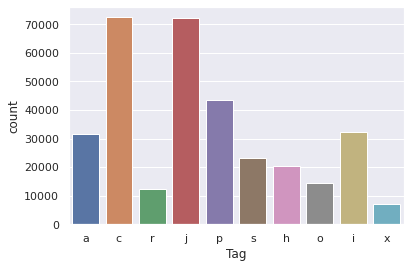

In [308]:
sns.set(style="darkgrid")
sns.countplot(x="Tag", data=train_data)

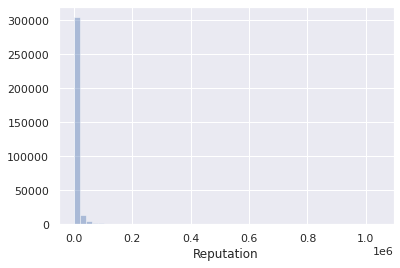

In [309]:
sns.distplot(train_data['Reputation'], kde=False)

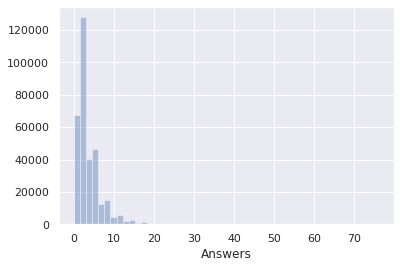

In [310]:

sns.distplot(train_data['Answers'], kde=False)

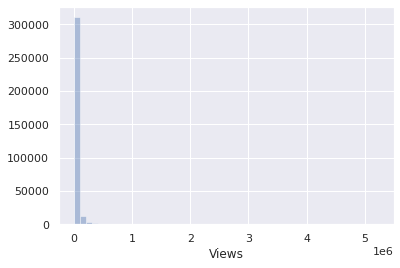

In [311]:
sns.distplot(train_data['Views'], kde=False)

#### Feature Engineering

In [312]:
num_features=['Reputation', 'Answers', 'Views']

#### 1. Getting polynomial features and selecting only newly created features

In [313]:
poly=PolynomialFeatures(degree=2,include_bias=False)
tmp=pd.DataFrame(poly.fit_transform(train_data[num_features])).loc[:,len(num_features):]
train_data=train_data.join(tmp)

In [314]:
tmp=pd.DataFrame(poly.transform(test_data[num_features])).loc[:,len(num_features):]
test_data=test_data.join(tmp)

#### 2.Tag-wise mean of numberical features

In [315]:
tmp=train_data.groupby('Tag')[num_features].mean()
tmp.columns=tmp.columns+'_mean'
train_data=pd.merge(train_data,tmp.reset_index(),how='left',on='Tag')

In [316]:
tmp=test_data.groupby('Tag')[num_features].mean()
tmp.columns=tmp.columns+'_mean'
test_data=pd.merge(test_data,tmp.reset_index(),how='left',on='Tag')

#### 3.Username wise count of upvotes. Fill nulls with 0

In [317]:
uname_count=train_data.groupby('Username')['Upvotes'].count().reset_index()
uname_count.rename(columns={'Upvotes':'User_Upvote_Count'},inplace=True)
train_data=pd.merge(train_data,uname_count,how='left',on='Username')
train_data['User_Upvote_Count'].fillna(0,inplace=True)

In [318]:
test_data=pd.merge(test_data,uname_count,how='left',on='Username')
test_data['User_Upvote_Count'].fillna(0,inplace=True)

In [319]:
train_data['uv']=train_data['Upvotes']/train_data['Views']
uname_uv=train_data.groupby('Username')['uv'].mean().reset_index()
uname_uv.rename(columns={'uv':'User_Upvote_Views_Mean'},inplace=True)
train_data=pd.merge(train_data,uname_uv,how='left',on='Username')
train_data['User_Upvote_Views_Mean'].fillna(0,inplace=True)

train_data.drop('uv',axis=1,inplace=True)

In [320]:
test_data=pd.merge(test_data,uname_uv,how='left',on='Username')
test_data['User_Upvote_Views_Mean'].fillna(0,inplace=True)

In [321]:
train_data.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,3,4,5,6,7,8,Reputation_mean,Answers_mean,Views_mean,User_Upvote_Count,User_Upvote_Views_Mean
0,52664,a,3942.0,2.0,155623,7855.0,42.0,15539364.0,7884.0,3.096441e+07,4.0,15710.0,6.170102e+07,6065.168102,4.259189,31800.916327,19,0.008671
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,678394116.0,312552.0,1.453393e+09,144.0,669612.0,3.113752e+09,6065.168102,4.259189,31800.916327,2,0.021218
2,468453,c,1358.0,4.0,56177,8067.0,60.0,1844164.0,5432.0,1.095499e+07,16.0,32268.0,6.507649e+07,10566.420657,4.047697,26746.676875,1,0.007438
3,96996,a,264.0,3.0,168793,27064.0,9.0,69696.0,792.0,7.144896e+06,9.0,81192.0,7.324601e+08,6065.168102,4.259189,31800.916327,3,0.000737
4,131465,c,4271.0,4.0,112223,13986.0,83.0,18241441.0,17084.0,5.973421e+07,16.0,55944.0,1.956082e+08,10566.420657,4.047697,26746.676875,3,0.005037


#### Encode Categorical Variable

In [322]:
train_data=pd.concat((train_data,pd.get_dummies(train_data.Tag,drop_first=True)),1)

In [323]:
train_data

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,3,4,5,...,User_Upvote_Views_Mean,c,h,i,j,o,p,r,s,x
0,52664,a,3942.0,2.0,155623,7855.0,42.0,15539364.0,7884.0,3.096441e+07,...,0.008671,0,0,0,0,0,0,0,0,0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,678394116.0,312552.0,1.453393e+09,...,0.021218,0,0,0,0,0,0,0,0,0
2,468453,c,1358.0,4.0,56177,8067.0,60.0,1844164.0,5432.0,1.095499e+07,...,0.007438,1,0,0,0,0,0,0,0,0
3,96996,a,264.0,3.0,168793,27064.0,9.0,69696.0,792.0,7.144896e+06,...,0.000737,0,0,0,0,0,0,0,0,0
4,131465,c,4271.0,4.0,112223,13986.0,83.0,18241441.0,17084.0,5.973421e+07,...,0.005037,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330040,339800,c,36.0,2.0,84919,1063.0,0.0,1296.0,72.0,3.826800e+04,...,0.000000,1,0,0,0,0,0,0,0,0
330041,253800,c,1649.0,2.0,76730,23319.0,73.0,2719201.0,3298.0,3.845303e+07,...,0.002925,1,0,0,0,0,0,0,0,0
330042,210756,c,6178.0,2.0,91701,2453.0,15.0,38167684.0,12356.0,1.515463e+07,...,0.013492,1,0,0,0,0,0,0,0,0
330043,56089,j,89.0,2.0,80245,2107.0,3.0,7921.0,178.0,1.875230e+05,...,0.001424,0,0,0,1,0,0,0,0,0


In [324]:
test_data=pd.concat((test_data,pd.get_dummies(test_data.Tag,drop_first=True)),1)

In [325]:
train_data.drop(['Tag','ID'],axis=1,inplace=True)
test_data.drop(['Tag','ID'],axis=1,inplace=True)

#### Remove target variable from train data

In [326]:
target_labels=train_data['Upvotes']
train_data.drop(['Upvotes'],axis=1,inplace=True)

#### Split data into train data , val data and test data 

In [327]:
X_train,X_test,y_train,y_test= train_test_split(train_data,target_labels,test_size=0.2,random_state=42)

In [328]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Scale train, val and test data

In [329]:
scaler=StandardScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_val=pd.DataFrame(scaler.transform(X_val),columns=X_val.columns,index=X_val.index)
X_test=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns,index=X_test.index)
test_data=pd.DataFrame(scaler.transform(test_data),columns=test_data.columns,index=test_data.index)

#### Create a basic baseline model using Linear Regression

In [330]:
def submission(model,test_data,filename):
    predictions=model.predict(test_data)
    ids=pd.read_csv(os.path.join(data,'test_data.csv'))['ID']
    submissions=pd.DataFrame({'ID':ids,'Upvotes':predictions})
    submissions.to_csv(filename + '.csv',index=False)
    print("Submissions saved in {} ".format(filename + '.csv'))

In [331]:
linear_reg=LinearRegression()

In [332]:
scoring='neg_mean_squared_error'

In [333]:
scores=cross_val_score(linear_reg,X_train,y_train,n_jobs=-1,cv=5,scoring=scoring)
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  885.2763921476624


In [334]:
linear_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [335]:
y_train_pred=linear_reg.predict(X_train)
y_val_pred=linear_reg.predict(X_val)
y_pred_lr=np.append(y_train_pred,y_val_pred)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

Train RMSE: 848.8878954757333
Test RMSE: 1543.7805505190079


In [336]:
submission(linear_reg,test_data,'linear_reg')

Submissions saved in linear_reg.csv 


#### Ridge Regression

In [337]:
ridge=Ridge()

In [338]:
scores=cross_val_score(ridge,X_train,y_train,n_jobs=-1,cv=5,scoring=scoring)
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  885.2672439250002


In [339]:
ridge.fit(X_train,y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [340]:
y_train_pred=ridge.predict(X_train)
y_val_pred=ridge.predict(X_val)
y_pred_lr=np.append(y_train_pred,y_val_pred)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

Train RMSE: 848.8878957333977
Test RMSE: 1543.7959153002294


In [341]:
submission(ridge,test_data,'ridge_reg')

Submissions saved in ridge_reg.csv 


#### XGBoost Regression

In [342]:
xgb_reg=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.200000012, max_delta_step=0, max_depth=12,
             min_child_weight=0, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [ ]:
xgb_reg.fit(X_train,y_train)
y_train_pred=xgb_reg.predict(X_train)
y_val_pred=xgb_reg.predict(X_val)
y_pred_xgb=np.append(y_train_pred,y_val_pred)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

In [ ]:
# Bayesian Optimization
opt = BayesSearchCV(
    estimator = xgb.XGBRegressor(
        n_jobs = -1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 20),
        'max_depth': Integer(3,4,5),
#         'max_delta_step': (0, 20),
        'subsample': Real(0.1, 1.0, 'uniform'),
        'colsample_bytree': Real(0.1, 1.0, 'uniform'),
        'colsample_bylevel': Real(0.1, 1.0, 'uniform'),
        'reg_lambda': Real(1e-1, 10, 'log-uniform'),
        'reg_alpha': Real(1e-1, 1.0, 'log-uniform'),
#         'gamma': (1e-9, 0.5, 'log-uniform'),
        'base_score':Real(1e-1, 0.5, 'log-uniform')
    },    
    scoring = scoring,
    cv =3,
    n_jobs = -1,
    refit = True,
    random_state = 42
)


In [ ]:
opt.fit(X_train,y_train)

In [ ]:
xgb_reg=xgb.XGBRegressor(random_state=0,n_jobs=-1,**opt.best_params_)
xgb_reg.fit(X_train,y_train)
y_train_pred=xgb_reg.predict(X_train)
y_val_pred=xgb_reg.predict(X_val)
y_pred_xgb=np.append(y_train_pred,y_val_pred)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

In [ ]:
submission(xgb_reg,test_data,'xgb_reg')

#### Stacking Linear Regression and Xgboost

In [ ]:
y_pred_stack=(y_pred_lr+y_pred_xgb)/2

In [ ]:
y_train_pred=y_pred_stack[:len(y_train)]
y_val_pred=y_pred_stack[len(y_train):]
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

#### Result on test data

In [ ]:
X_train_1=pd.concat([X_train,X_val])
y_train_1=pd.concat([y_train,y_val])

In [ ]:
linear_reg.fit(X_train_1,y_train_1)
y_pred_lr=linear_reg.predict(X_test)

In [ ]:
xgb_reg.fit(X_train_1,y_train_1)
y_pred_xgb=xgb_reg.predict(X_test)

In [ ]:
y_pred_stack=(y_pred_lr+y_pred_xgb)/2
print('Test RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_stack)))

#### Submisssion for stacking

In [ ]:
y_pred_lr=linear_reg.predict(test_data)
y_pred_xgb=xgb_reg.predict(test_data)

In [ ]:
y_pred_stacked=(y_pred_lr+y_pred_xgb)/2

In [ ]:
test_ids=pd.read_csv(os.path.join(data,'test_data.csv'))['ID']

In [ ]:
submission=pd.DataFrame({'ID':test_ids})
submission['Upvotes']=list(map(int,y_pred_stacked))

In [ ]:
submission.to_csv("stacking.csv",index=False)